# Standardizing and Proxy Recovery Time calculation

#### 1. Data Ingestion and Initial Assessment

The analysis begins with loading the merged exercise and sleep dataset, which forms the basis for deriving our proxy recovery time metric. By examining the overall shape of the data, we confirm that all user-day observations have been captured correctly. A detailed review of each column’s data type and non-null count helps us identify any inconsistencies or missing entries that could skew later calculations. Inspecting a handful of sample rows further validates that key variables—such as active duration, step count, sleep duration, and sleep efficiency—are present, accurately labeled, and formatted as expected. These initial checks ensure that the foundational dataset is reliable and complete, setting the stage for robust computation and smoothing of the recovery time proxy.  


In [1]:
# 1. Load and inspect data
# Import libraries
import pandas as pd

# Load the data from data/curated folder
df = pd.read_csv('../data/curated/exercise_sleep_combined.csv')

# Shape of the dataset
print(f"Dataset shape: {df.shape}\n")  # (rows, columns)

# Inspect data types and non‐null counts
df.info()

print("\n")

# Few sample rows
df.head(5)

Dataset shape: (1250, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   personId                       1250 non-null   object 
 1   date                           1250 non-null   object 
 2   exercise_activeDuration_in_ms  1250 non-null   int64  
 3   exercise_steps                 1250 non-null   float64
 4   exercise_calories              1250 non-null   int64  
 5   exercise_elevationGain         1250 non-null   float64
 6   exercise_averageHeartRate      1246 non-null   float64
 7   sleep_duration_in_ms           1250 non-null   int64  
 8   sleep_minutesAsleep            1250 non-null   int64  
 9   sleep_minutesAwake             1250 non-null   int64  
 10  sleep_efficiency               1250 non-null   float64
dtypes: float64(4), int64(5), object(2)
memory usage: 107.6+ KB




,personId,date,exercise_activeDuration_in_ms,exercise_steps,exercise_calories,exercise_elevationGain,exercise_averageHeartRate,sleep_duration_in_ms,sleep_minutesAsleep,sleep_minutesAwake,sleep_efficiency
0,p01,2019-11-02,2458000,3035.0,354,21.34,98.0,25800000,378,52,97.0
1,p01,2019-11-04,1024000,1284.0,145,21.34,97.0,23940000,361,38,96.0
2,p01,2019-11-05,2433000,4966.0,517,41.45,118.5,21720000,326,36,99.0
3,p01,2019-11-08,1844000,2094.0,252,24.38,97.0,23520000,360,32,100.0
4,p01,2019-11-09,3123000,4185.0,454,64.01,97.0,23460000,344,47,99.0


#### 2. Missing Data Imputation

To address gaps in our key exercise and sleep measurements, we replace missing entries with the median value of each respective variable. Median imputation is robust to outliers and preserves the central tendency of the data without distorting distributions. A final check confirms that all numeric columns are now complete, ensuring that subsequent computations of proxy recovery time will not be compromised by NaNs.  

In [2]:
# 2. Handle missing values by filling them with coloumn-wise median

# Identify numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Impute missing values with the column‐wise median
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Verify that no numeric column has missing values
print("Missing values after imputation:")
print(df[numeric_cols].isna().sum())

Missing values after imputation:
exercise_activeDuration_in_ms    0
exercise_steps                   0
exercise_calories                0
exercise_elevationGain           0
exercise_averageHeartRate        0
sleep_duration_in_ms             0
sleep_minutesAsleep              0
sleep_minutesAwake               0
sleep_efficiency                 0
dtype: int64


#### 3. Per-User Feature Standardization

Because each individual may have a unique baseline for exercise and sleep metrics, we normalize all numeric features within each user’s data. By grouping on `personId` and applying a z-score transformation—subtracting the user’s mean and dividing by their standard deviation—we align each metric to a common scale with mean zero and unit variance. This step removes inter-user scale differences while preserving day-to-day variability, which is crucial for fair model training. A quick sanity check confirms that, after transformation, every feature exhibits an overall mean of approximately zero and a standard deviation of one. With features standardized in this way, the model can learn patterns without being unduly influenced by users with inherently higher or lower raw values.  

In [3]:
# 3. Standardize numeric features per user
numeric_cols = df.select_dtypes(include='number').columns

df[numeric_cols] = (
    df
    .groupby('personId')[numeric_cols]
    .transform(lambda x: (x - x.mean()) / x.std())
)

# quick sanity check
print(df[numeric_cols].agg(['mean','std']).round(3))


      exercise_activeDuration_in_ms  exercise_steps  exercise_calories  \
mean                         -0.000           0.000             -0.000   
std                           0.994           0.994              0.994   

      exercise_elevationGain  exercise_averageHeartRate  sleep_duration_in_ms  \
mean                   0.000                     -0.000                 0.000   
std                    0.994                      0.994                 0.994   

      sleep_minutesAsleep  sleep_minutesAwake  sleep_efficiency  
mean               -0.000              -0.000            -0.000  
std                 0.994               0.994             0.994  


#### 4. Composite Recovery Score Calculation

To quantify recovery in a single metric, we combine exercise and sleep measures into a unified “recovery score.” First, **training load** is defined as the sum of active duration and calories burned, reflecting physical exertion. Next, **sleep score** aggregates minutes asleep and sleep efficiency, capturing restorative rest. The final **recovery score** is computed as the difference between sleep score and training load, so that higher values indicate better recovery relative to the preceding exercise load. A quick inspection of the resulting range confirms that the score varies meaningfully across days and users, providing a balanced proxy for physiological recovery.  


In [4]:
# 4. Compute composite recovery score
df['training_load']   = df['exercise_activeDuration_in_ms'] + df['exercise_calories']
df['sleep_score']     = df['sleep_minutesAsleep'] + df['sleep_efficiency']
df['recovery_score']  = df['sleep_score'] - df['training_load']

# sanity check
print(df['recovery_score'].agg(['min','mean','max']).round(3))


min    -13.954
mean    -0.000
max      9.496
Name: recovery_score, dtype: float64


#### 5. Percentile-Based Transformation to Recovery Hours

To translate our unitless recovery score into an interpretable measure of recovery time (in hours), we use each user’s empirical distribution to set personalized bounds. Specifically, we compute the 2nd and 98th percentiles of the recovery score for each individual—this captures the typical lower and upper extremes while ignoring outliers. We then **clip** each day’s recovery score to this percentile range and **linearly rescale** it into a fixed [0, 48]-hour window. Days with low scores (near the 2nd percentile) map to close to 48 hours of “recovery needed,” while days with high scores (near the 98th percentile) map near 0 hours, indicating minimal required recovery. This strategy produces a smooth, bounded proxy—`recovery_hours`—that reflects each user’s relative recovery state in a consistent, comparable time metric.  


In [5]:
# 5. Percentile-based mapping INTO recovery_hours (per user, wider bounds)
# 5.1 Compute per-user 2nd and 98th percentiles of recovery_score
import numpy as np

min_hours, max_hours = 0, 48.0

p_low = df.groupby('personId')['recovery_score'] \
          .transform(lambda x: np.percentile(x, 2))
p_high = df.groupby('personId')['recovery_score'] \
           .transform(lambda x: np.percentile(x, 98))

# 5.2 Map into recovery_hours 
df['recovery_hours'] = (
    max_hours
    - (np.clip(df['recovery_score'], p_low, p_high) - p_low)
      / (p_high - p_low)
      * (max_hours - min_hours)
)

# 5.3 Sanity check
print(df[['recovery_score','recovery_hours']].agg(['min','mean','max']).round(2))



      recovery_score  recovery_hours
min           -13.95            0.00
mean           -0.00           21.78
max             9.50           48.00


#### 6. Temporal Smoothing of Recovery Hours

Raw daily estimates of recovery hours can fluctuate due to natural variability in activity and sleep. To capture more stable trends, we apply a **7-day rolling average** separately for each user. By grouping on `personId` and computing the mean of each seven-day window (with at least one observation), we smooth out short-term spikes and dips, revealing underlying recovery patterns over the prior week. This smoothed target—`recovery_hours_smooth`—serves as a more reliable outcome for modeling, reducing noise and improving the stability of model training and evaluation.  

In [6]:
# 6. Smooth the target with a 7-day rolling window
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['personId','date'])

df['recovery_hours_smooth'] = (
    df
    .groupby('personId')['recovery_hours']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)


#### 7. Visualization of Raw and Smoothed Recovery Time

To illustrate the effect of smoothing, we plot both the original daily `recovery_hours` and its 7-day rolling average for a sample user. The faint, point-connected line represents the day-to-day estimates, which exhibit rapid fluctuations driven by varying exercise loads and sleep quality. Overlaid is the thicker curve of the 7-day smoothed values, which dampens short-term spikes and troughs to reveal longer-term recovery trends. This comparison highlights how smoothing reduces noise and stabilizes the target variable, providing a clearer signal for our machine learning models to learn meaningful patterns rather than overfitting transient variability.  


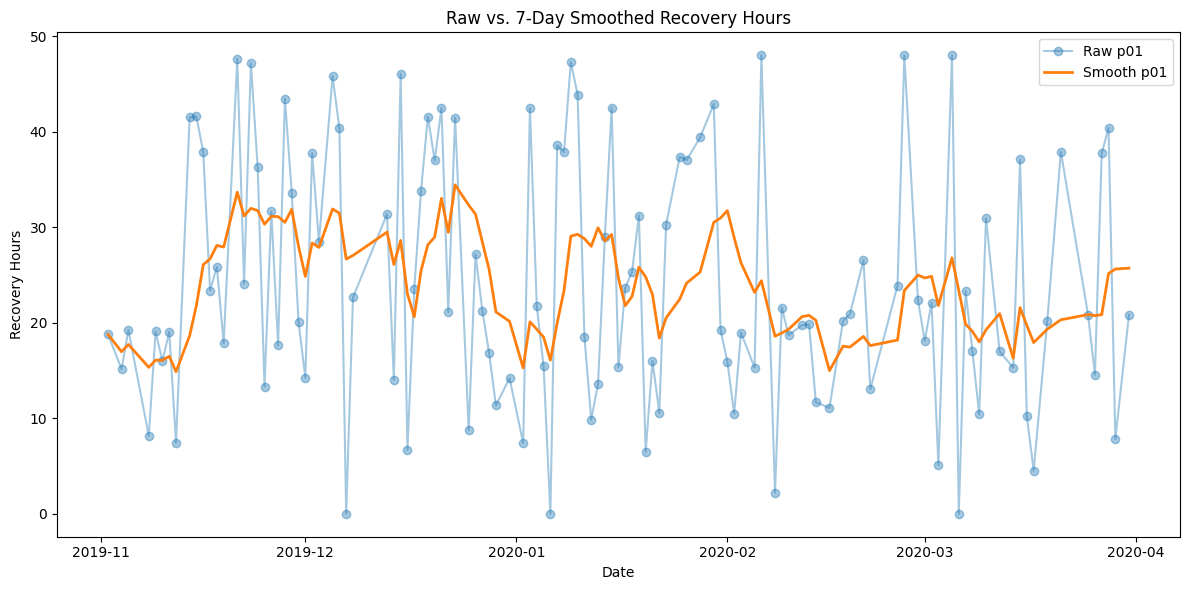

In [7]:
# 7. Plot raw vs. smoothed recovery hours for sample users
import matplotlib.pyplot as plt

# pick a few users to visualize
sample_users = df['personId'].unique()[0:1]

plt.figure(figsize=(12, 6))
for user in sample_users:
    user_df = df[df['personId'] == user]
    # raw
    plt.plot(user_df['date'], 
             user_df['recovery_hours'], 
             alpha=0.4, 
             marker='o', 
             linestyle='-', 
             label=f'Raw {user}')
    # smoothed
    plt.plot(user_df['date'], 
             user_df['recovery_hours_smooth'], 
             linewidth=2, 
             label=f'Smooth {user}')

plt.xlabel('Date')
plt.ylabel('Recovery Hours')
plt.title('Raw vs. 7-Day Smoothed Recovery Hours')
plt.legend()
plt.tight_layout()
plt.show()


#### 8. Exporting the Final Modeling Dataset

Having computed and smoothed the personalized recovery time metric, the final step is to persist this enriched dataset for downstream modeling. By saving the DataFrame—including all standardized features, the proxy recovery hours, and its 7-day rolling average—to a CSV file, we create a stable, self‐contained input that can be loaded directly into our modeling pipeline. This export ensures reproducibility, allows seamless handoff between preprocessing and machine learning workflows, and provides a clear, versioned snapshot of the data exactly as it will be used for training and evaluation.  


In [8]:
# 8. Save the ready-for-modeling dataset
output_path = '../data/curated/recovery_time_ready_for_model.csv'
df.to_csv(output_path, index=False)
print(f"Saved processed data to {output_path}")

Saved processed data to ../data/curated/recovery_time_ready_for_model.csv
